# Setup

In [1]:
import datetime
import numpy as np
import pandas as pd
import pickle
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [2]:
%reload_ext autoreload
%autoreload 2

src_path = "/Users/aarontrefler_temp2/Documents/My Documents/Kaggle/ncaa-men-19/src"
sys.path.insert(0, src_path)

import models

from utils import cols_to_front, display_df

pd.options.display.max_columns = 999

In [3]:
data_clean_dir = '../data/clean/'

# Read Data

In [4]:
df_clean = pd.read_csv(data_clean_dir + 'model_dataset.csv')
df_clean_sub = pd.read_csv(data_clean_dir + 'submission_dataset.csv')

In [5]:
display_df(df_clean, n=5, tail=True, title="Tournament Games")
display_df(df_clean_sub, n=5, tail=True, title="Submission File Games")

Tournament Games:


,Season,TeamOne_Name,TeamTwo_Name,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,1985.0,Alabama,Arizona,1.0,1104.0,1112.0,7.0,10.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,-3.0,0.0,0.490111,0.153702,0.050672,0.344328
1,1985.0,Alabama,VA Commonwealth,1.0,1104.0,1433.0,7.0,2.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,5.0,0.0,0.490111,0.153702,0.050672,0.344328
2,1985.0,Alabama,NC State,0.0,1104.0,1301.0,7.0,3.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,

,Season,TeamOne_Name,TeamTwo_Name,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2137,2018.0,Tennessee,Wright St,1.0,1397.0,1460.0,3.0,14.0,15.818182,10.818182,4.484848,3.303030,24.484848,23.090909,57.484848,20.454545,19.939394,54.939394,25.242424,7.848485,6.363636,22.515152,21.000000,21.060606,15.878788,15.000000,0.060606,11.666667,11.242424,19.575758,19.515152,74.212121,66.393939,6.303030,5.636364,12.212121,13.939394,68.005303,67.640152,109.414278,98.163525,11.250753,67.822727,13.218750,11.843750,2.281250,2.906250,26.093750,25.093750,57.531250,20.125000,22.281250,56.093750,24.781250,6.843750,7.781250,23.187500,20.718750,16.812500,14.906250,12.000000,0.062500,10.125000,8.687500,16.031250,20.031250,71.312500,66.156250,6.593750,5.906250,13.062500,14.843750,70.310156,70.235938,101.332394,94.131659,7.200736,70.273047,2.599432,-1.025568,2.203598,0.396780,-1.608902,-2.002841,-0.046402,-1.154356,0.329545,-2.341856,0.461174,-0.672348,1.004735,-1.417614,0.281250,4.248106,0.972538,3.000000,1.541667,2.554924,3.544508,-0.516098,2.899621,0.237689,-0.290720,-0.269886,-0.850379,-0.904356,-2.304853,-2.595786,-11.0,-0.001894,8.081884,4.031867,4.050017,-2.450320
2138,2018.0,Texas Tech,Villanova,0.0,1403.0,1437.0,3.0,1.0,14.424242,10.363636,4.272727,3.636364,24.939394,21.939394,56.363636,19.212121,20.969697,54.030303,26.151515,7.030303,6.878788,21.757576,22.696970,20.545455,15.909091,14.303030,0.060606,11.000000,9.818182,18.151515,20.878788,75.242424,64.696970,7.393939,5.939394,12.545455,15.181818,68.690152,69.153030,109.643838,93.850766,15.793072,68.921591,16.676471,14.000000,3.970588,2.676471,26.205882,23.147059,61.529412,28.676471,21.352941,60.205882,31.029412,11.411765,7.000000,26.147059,17.617647,15.382353,13.588235,11.588235,0.088235,9.382353,9.558824,15.852941,17.235294,87.058824,70.882353,6.676471,4.558824,10.352941,13.117647,70.868382,71.071324,122.981400,99.758537,23.222863,70.969853,-2.252228,-3.636364,0.302139,0.959893,-1.266488,-1.207665,-5.165775,-6.175579,-9.464349,-0.383244,-4.877897,-4.389483,-4.381462,-0.121212,5.079323,5.163102,2.320856,2.714795,1.617647,0.259358,2.298574,3.643494,-11.816399,-6.185383,0.717469,1.380570,2.192513,2.064171,-2.178231,-1.918293,2.0,-0.027629,-13.337562,-5.907771,-7.429791,-2.048262
2139,2018.0,TX Southern,Xavier,0.0,1411.0,1462.0,16.0,1.0,12.264706,15.882353,3.941176,3.911765,25.882353,25.794118,58.500000,21.529412,21.352941,64.323529,25.823529,7.823529,7.911765,29.176471,25.294118,20.176471,18.176471,13.470588,0.058824,10.294118,12.264706,17.735294,21.088235,77.647059,79.735294,5.588235,5.294118,12.617647

(2142, 114)

Submission File Games:


,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,2019.0,Abilene Chr,Arizona St,1101.0,1113.0,15.0,11.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,13.593750,13.281250,3.218750,3.468750,27.812500,25.218750,59.468750,21.250000,25.500000,58.687500,26.593750,7.250000,8.562500,24.218750,25.906250,22.656250,17.375000,16.062500,0.03125,12.156250,10.000000,19.906250,21.656250,77.812500,73.062500,6.218750,6.343750,13.593750,13.906250,73.211719,73.355469,106.521506,99.660084,6.861422,73.283594,1.026940,-2.177802,-0.667026,-0.503233,-4.915948,-1.460129,-4.227371,-7.549569,-2.353448,-8.396552,-1.248922,-1.735991,-0.008621,-2.838362,-6.837284,-3.001078,-3.581897,-1.855603,-3.087284,-1.172414,-0.768319,-3.587284,-6.088362,-8.165948,1.781250,-0.792026,-1.938578,1.817888,-6.326374,-5.984779,4.0,-0.03125,0.953377,-3.243674,4.197052,-6.155577
1,2019.0,Abilene Chr,Auburn,1101.0,1120.0,15.0,5.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,14.411765,12.029412,4.764706,3.676471,21.941176,24.176471,60.441176,29.970588,23.382353,52.941176,27.029412,11.411765,8.323529,23.235294,18.735294,19.352941,13.411765,13.794118,0.00000,11.735294,10.764706,18.382353,17.205882,78.882353,68.588235,9.294118,5.911765,12.147059,17.588235,69.752206,68.957353,113.004517,99.688575,13.315942,69.354779,0.208925,-0.925963,-2.212982,-0.710953,0.955375,-0.417850,-5.199797,-1.803245,-11.074037,-6.278905,-1.684584,-0.752535,-4.170385,-2.599391,0.333671,0.302231,0.381339,0.412779,-2.666329,-1.937120,0.755578,0.863083,-7.158215,-3.691684,-1.294118,-0.360041,-0.491886,-1.864097,-2.866861,-1.586663,10.0,0.00000,-5.529633,-3.272165,-2.257469,-2.226762
2,2019.0,Abilene Chr,Baylor,1101.0,1124.0,15.0,9.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,1

,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2273,2019.0,Washington,Wofford,1449.0,1459.0,9.0,7.0,11.676471,13.117647,5.735294,2.470588,22.117647,22.529412,54.264706,21.588235,19.117647,54.147059,24.558824,7.470588,6.323529,22.441176,19.058824,18.676471,13.235294,13.176471,0.0,9.470588,11.647059,18.411765,18.411765,69.823529,64.382353,9.000000,6.147059,13.352941,16.235294,67.200000,67.606618,103.903790,95.316150,8.587640,67.403309,14.7,11.633333,2.933333,2.566667,24.433333,21.600000,60.100000,26.133333,22.100000,54.966667,29.300000,10.866667,7.233333,23.966667,16.633333,17.500000,11.733333,12.366667,0.0,10.300000,7.966667,17.5,15.700000,81.200000,67.533333,6.133333,5.600000,11.233333,13.266667,68.934167,68.579167,117.576692,98.064257,19.512435,68.756667,-3.023529,1.484314,2.801961,-0.096078,-2.315686,0.929412,-5.835294,-0.819608,-4.545098,-2.982353,-4.741176,-1.525490,-3.396078,-0.909804,2.425490,1.176471,1.501961,0.809804,-0.829412,3.680392,0.911765,2.711765,-11.376471,-3.150980,2.866667,0.547059,2.119608,2.968627,-1.734167,-0.972549,2.0,0.0,-13.672901,-2.748107,-10.924795,-1.353358
2274,2019.0,Washington,Yale,1449.0,1463.0,9.0,14.0,11.676471,13.117647,5.735294,2.470588,22.117647,22.529412,54.264706,21.588235,19.117647,54.147059,24.558824,7.470588,6.323529,22.441176,19.058824,18.676471,13.235294,13.176471,0.0,9.470588,11.647059,18.411765,18.411765,69.823529,64.382353,9.000000,6.147059,13.352941,16.235294,67.200000,67.606618,103.903790,95.316150,8.587640,67.403309,17.0,12.678571,4.321429,2.964286,29.821429,24.357143,60.107143,20.821429,24.071429,63.035714,29.821429,7.785714,7.500000,26.000000,18.357143,19.285714,13.464286,14.214286,0.0,8.678571,9.607143,17.0,17.142857,80.892857,73.714286,5.750000,7.107143,13.250000,11.214286,73.398214,73.803571,110.407243,99.723764,10.683479,73.600893,-5.323529,0.439076,1.413866,-0.493697,-7.703782,-1.827731,-5.842437,-8.888655,0.766807,-4.953782,-5.262605,-3.558824,-0.315126,-1.176471,0.701681,-0.609244,-0.228992,-1.037815,0.792017,2.039916,1.411765,1.268908,-11.069328,-9.331933,3.250000,-0.960084,0.102941,5.021008,-6.198214,-6.196954,-5.0,0.0,-6.503452,-4.407613,-2.095839,-6.197584
2275,2019.0,Wisconsin,Wofford,1458.0,1459.0,5.0,7.0,12.757576,10.303030,4.212121,4.030303,27.060606,25.757576,57.121212,19.454545,20.212121,57.545455,25.878788,7.121212,6.303030,22.606061,15.696970,14.909091,10.181818,9.909091,0.0,8.151515,9.757576,15.060606,17.484848,69.060606,61.424242,5.121212,5.151515,9.545455,11.363636,65.971212,66.233333,104.505310,92.729393,11.775917,66.102273,14.7,11.6

(2278, 113)

# Train / Validation Split

In [6]:
df_train = df_clean.loc[df_clean.Season.isin(np.arange(1985, 2014))]
df_valid = df_clean.loc[df_clean.Season.isin(np.arange(2014, 2019))]

# Train Model

In [36]:
features = list(set(df_clean.columns) - set(
    ['Label', 'Season', 'TeamOneID', 'TeamTwoID', 'TeamOne_Name', 'TeamTwo_Name']))

In [37]:
# Create custom cross validator object based off train-validation split
test_fold = np.concatenate((np.zeros(len(df_train)) - 1, np.zeros(len(df_valid))))
ps_cv = PredefinedSplit(test_fold)

# Hyper-parameter optimization
parameters = {
    'min_samples_split': [25, 50, 75],
    'n_estimators': [100, 500],
    'random_state': [3]
}
clf = RandomForestClassifier()
gridcv = GridSearchCV(clf, parameters, cv=ps_cv, scoring=['neg_log_loss', 'accuracy'], 
    refit='neg_log_loss', error_score='raise', n_jobs=2, return_train_score=True)

X = df_clean[features].values
y = df_clean.Label.values
gridcv.fit(X, y)

# Create classifier with optimal hyper-parameters
clf = RandomForestClassifier(**gridcv.best_params_)
print(gridcv.best_params_)

{'random_state': 3, 'min_samples_split': 50, 'n_estimators': 100}


In [38]:
# Display CV results
display(
    pd.DataFrame(gridcv.cv_results_)
    .sort_values('rank_test_neg_log_loss')
    .pipe(cols_to_front, ['mean_test_neg_log_loss', 'mean_test_accuracy', 
                          'mean_train_neg_log_loss', 'mean_train_accuracy'])
    .head()
)

,mean_test_neg_log_loss,mean_test_accuracy,mean_train_neg_log_loss,mean_train_accuracy,mean_fit_time,mean_score_time,param_min_samples_split,param_n_estimators,param_random_state,params,rank_test_accuracy,rank_test_neg_log_loss,split0_test_accuracy,split0_test_neg_log_loss,split0_train_accuracy,split0_train_neg_log_loss,std_fit_time,std_score_time,std_test_accuracy,std_test_neg_log_loss,std_train_accuracy,std_train_neg_log_loss
2,-0.577382,0.704762,-0.455276,0.807882,0.267919,0.023539,50,100,3,"{'random_state': 3, 'min_samples_split': 50, '...",5,1,0.704762,-0.577382,0.807882,-0.455276,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.579005,0.717460,-0.456407,0.808976,0.969438,0.094556,50,500,3,"{'random_state': 3, 'min_samples_split': 50, '...",1,2,0.717460,-0.579005,0.808976,-0.456407,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.582338,0.711111,-0.471237,0.798030,0.801287,0.085304,75,500,3,"{'random_state': 3, 'min_samples_split': 75, '...",2,3,0.711111,-0.582338,0.798030,-0.471237,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.585088,0.711111,-0.429489,0.829776,1.077743,0.133130,25,500,3,"{'random_state': 3, 'min_samples_split': 25, '...",2,4,0.711111,-0.585088,0.829776,-0.429489,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.586175,0.711111,-0.469684,0.799672,0.279736,0.017820,75,100,3,"{'random_state': 3, 'min_samples_split': 75, '...",2,5,0.711111,-0.586175,0.799672,-0.469684,0.0,0.0,0.0,0.0,0.0,0.0


# Make Predictions

## Training Set

In [43]:
y_train = df_train.Label.values
X_train = df_train[features].values

clf.fit(X_train, y_train)
yp_train = models.clip_preds(clf.predict_proba(X_train)[:, 1])

score_train = log_loss(y_train, yp_train, normalize=True)
acc_train = sum(np.round(yp_train) == y_train) / len(y_train)

print("Logloss:", score_train)
print("Accuracy:", acc_train)

Logloss: 0.457108701234
Accuracy: 0.807881773399


## Validation Set

In [44]:
y_valid = df_valid.Label.values
X_valid = df_valid[features].values

yp_valid = models.clip_preds(clf.predict_proba(X_valid)[:, 1])

score_valid = log_loss(y_valid, yp_valid, normalize=True)
acc_valid = sum(np.round(yp_valid) == y_valid) / len(y_valid)

print("Logloss:", score_valid)
print("Accuracy:", acc_valid)

Logloss: 0.577381613094
Accuracy: 0.704761904762


## Submisison Set (2019)

In [45]:
X_sub = df_clean_sub[features].values

 # us classifier re-trained on both train and validation data
yp_sub = models.clip_preds(gridcv.best_estimator_.predict_proba(X_sub)[:, 1]) 

# Analyze Model

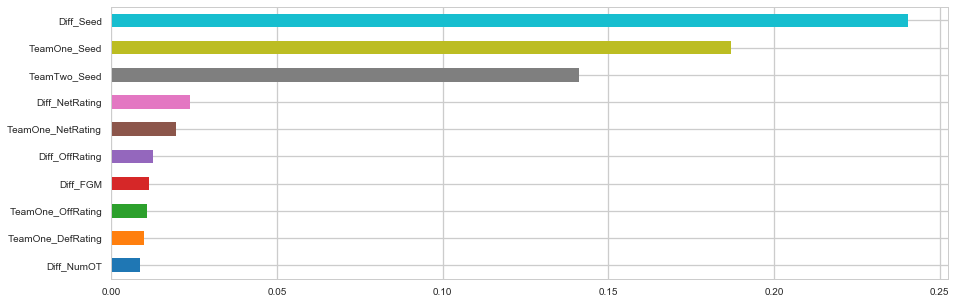

In [46]:
(
    pd.Series(clf.feature_importances_, index=df_train[features].columns)
    .nlargest(n=10)
    .sort_values()
    .plot(kind='barh', figsize=(15, 5), fontsize=10)

)
plt.show()

# Analyze Predictions

In [47]:
df_train_pred = (
    df_train
    .assign(Pred=yp_train)
    .pipe(models.compute_logloss)
    .sort_values('Logloss', ascending=False)
    .pipe(cols_to_front, front_cols=['Logloss', 'Label', 'Pred'])
)

df_valid_pred = (
    df_valid
    .assign(Pred=yp_valid)
    .pipe(models.compute_logloss)
    .sort_values('Logloss', ascending=False)
    .pipe(cols_to_front, front_cols=['Logloss', 'Label', 'Pred'])      
)

df_sub_pred = (
    df_clean_sub
    .assign(Pred=yp_sub)
    .pipe(cols_to_front, front_cols=['Pred'])      
)

In [48]:
display_df(df_train_pred, n=5, tail=True, title='Training Predictions')
display_df(df_valid_pred, n=5, tail=True, title='Validation Predictions')
display_df(df_sub_pred, n=5, tail=True, title='Submission Predictions')

Training Predictions:


,Logloss,Label,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
504,2.995732,0.0,0.950000,1993.0,Arizona,Santa Clara,1112.0,1365.0,2.0,15.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,-13.0,0.0,0.490111,0.153702,0.050672,0.344328
783,2.498029,1.0,0.082247,1997.0,Coppin St,South Carolina,1164.0,1376.0,15.0,2.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,13.0,0.0,0.490111,0.153702,0.050672,0.344328
434,2.498029,1.0,0.082247,1991.0,Richmond,Syracuse,1350.0,1393.0,15.0,2.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.55

,Logloss,Label,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
44,0.051293,1.0,0.95,1985.0,Memphis,Penn,1272.0,1335.0,2.0,15.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,-13.0,0.0,0.490111,0.153702,0.050672,0.344328
786,0.051293,0.0,0.05,1997.0,Fairfield,North Carolina,1193.0,1314.0,16.0,1.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,15.0,0.0,0.490111,0.153702,0.050672,0.344328
193,0.051293,1.0,0.95,1988.0,Arizona,Cornell,1112.0,1165.0,1.0,16.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.9517

(1827, 116)

Validation Predictions:


,Logloss,Label,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
1992,1.707787,0.0,0.818734,2016.0,Michigan St,MTSU,1277.0,1292.0,2.0,15.0,20.558824,10.617647,5.147059,3.235294,29.558824,20.735294,59.529412,21.029412,18.794118,57.823529,28.794118,9.117647,5.676471,21.794118,17.882353,19.676471,13.058824,14.117647,0.058824,12.294118,9.352941,19.088235,17.558824,79.764706,63.382353,4.411765,5.323529,11.794118,9.558824,67.523529,67.375735,118.026062,93.920597,24.105465,67.449632,13.032258,11.451613,3.483871,2.774194,26.548387,26.064516,57.709677,20.580645,18.354839,54.322581,25.903226,8.000000,6.258065,23.225806,20.612903,23.225806,12.516129,15.516129,0.032258,10.258065,9.064516,20.451613,18.838710,72.322581,68.225806,6.258065,5.838710,11.935484,13.516129,69.178226,69.806452,104.563218,98.062200,6.501018,69.492339,7.526565,-0.833966,1.663188,0.461101,3.010436,-5.329222,1.819734,3.500949,0.448767,0.439279,2.890892,-1.431689,1.117647,-0.581594,-2.730550,-3.549336,0.542694,-1.398482,2.036053,0.288425,-1.363378,-1.279886,7.442125,-4.843454,-1.846300,-0.515180,-0.141366,-3.957306,-1.654696,-2.430716,-13.0,0.026565,13.462843,-4.141604,17.604447,-2.042706
2125,1.516586,0.0,0.780540,2018.0,Michigan St,Syracuse,1277.0,1393.0,3.0,11.0,19.333333,12.212121,7.363636,2.454545,29.787879,19.545455,56.727273,20.333333,21.818182,60.939394,28.575758,8.393939,7.272727,22.303030,20.545455,17.818182,15.424242,12.909091,0.030303,11.060606,10.909091,18.060606,19.848485,80.969697,64.787879,4.090909,6.030303,13.181818,9.969697,68.607576,68.463636,117.834553,95.013194,22.821359,68.535606,10.969697,16.181818,5.575758,3.181818,25.333333,22.393939,54.424242,18.181818,24.181818,55.272727,22.757576,5.848485,7.939394,21.878788,21.848485,17.303030,16.181818,12.848485,0.121212,12.090909,10.484848,16.303030,18.393939,67.545455,64.545455,7.242424,6.303030,12.575758,12.848485,65.287121,65.855303,103.495693,97.913277,5.582417,65.571212,8.363636,-3.969697,1.787879,-0.727273,4.454545,-2.848485,2.303030,5.666667,2.151515,-2.363636,5.818182,0.424242,2.545455,-0.666667,-1.303030,0.515152,-0.757576,0.060606,-1.030303,0.424242,1.757576,1.454545,13.424242,0.242424,-3.151515,-0.272727,0.606061,-2.878788,3.320455,2.608333,-8.0,-0.090909,14.338860,-2.900082,17.238942,2.964394
2016,1.494626,0.0,0.775667,2017.0,Arizona,Xavier,1112.0,1462.0,2.0,11.0,13.794118,12.647059,3.235294,3.000000,26.470588,20.558824,55.088235,16.941176,20.941176,57.205882,26.205882,6.735294,6.411765,23.764706,22.588235,16.676471,17.117647,11.500000,0.000000,10.294118,9.382353,16.970588,19

,Logloss,Label,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2049,0.105691,0.0,0.100297,2017.0,Jacksonville St,Louisville,1240.0,1257.0,15.0,2.0,13.812500,11.500000,3.656250,2.937500,25.156250,21.937500,53.500000,19.593750,20.687500,55.125000,24.437500,7.187500,7.843750,23.250000,18.093750,19.187500,12.968750,13.812500,0.062500,10.093750,9.781250,18.218750,17.781250,69.031250,68.156250,4.531250,5.781250,13.531250,10.968750,65.532031,65.426562,105.605913,103.995573,1.610340,65.479297,13.593750,10.687500,5.468750,3.312500,26.375000,23.312500,61.281250,19.875000,19.906250,55.937500,27.906250,7.125000,6.156250,22.156250,21.312500,22.250000,14.593750,15.375000,0.062500,13.312500,10.625000,19.468750,18.625000,77.531250,65.843750,6.750000,5.125000,11.156250,13.718750,69.248437,69.600000,112.016725,95.095835,16.920890,69.424219,0.218750,0.812500,-1.812500,-0.375000,-1.218750,-1.375000,-7.781250,-0.812500,-0.281250,0.781250,-3.468750,1.093750,0.062500,1.687500,-3.218750,-3.062500,-1.625000,-1.562500,-3.218750,-0.843750,-1.250000,-0.843750,-8.500000,2.312500,-2.218750,0.656250,2.375000,-2.750000,-3.716406,-4.173438,13.0,0.000000,-6.410811,8.899738,-15.310550,-3.944922
1971,0.103295,0.0,0.098139,2016.0,FL Gulf Coast,North Carolina,1195.0,1314.0,16.0,1.0,12.896552,12.034483,4.034483,3.310345,27.965517,24.862069,60.068966,14.655172,22.068966,60.103448,28.206897,5.068966,6.827586,25.482759,21.862069,21.689655,14.103448,15.068966,0.241379,11.448276,10.586207,19.620690,18.896552,75.586207,72.862069,6.137931,6.620690,12.000000,11.551724,71.005172,71.371552,106.832315,102.100938,4.731378,71.188362,18.117647,11.264706,4.382353,3.088235,26.941176,21.264706,64.323529,17.147059,21.411765,60.205882,30.794118,5.382353,7.705882,24.676471,20.735294,17.882353,15.294118,12.500000,0.000000,14.029412,11.441176,17.911765,18.205882,82.264706,69.558824,6.882353,5.764706,10.911765,13.147059,71.055147,70.405882,115.741865,99.074907,16.666958,70.730515,-5.221095,0.769777,-0.347870,0.222110,1.024341,3.597363,-4.254564,-0.102434,-2.491886,0.657201,-2.587221,0.806288,-0.313387,-0.878296,1.126775,3.807302,-1.190669,2.568966,-2.581136,-0.854970,1.708925,0.690669,-6.678499,3.303245,-0.744422,0.855984,1.088235,-1.595335,-0.049975,0.965669,15.0,0.241379,-8.909550,3.026030,-11.935580,0.457847
2029,0.101566,1.0,0.903422,2017.0,Cincinnati,Kansas St,1153.0,1243.0,6.0,11.0,15.823529,11.029412,5.088235,3.088235,24.794118,22.235294,59.294118,21.588235,20.117647,54.676471,26.941176,7.411765,6.852941,21.029412,19.294118,16.176471,13.176471,11.911765,0.058

(315, 116)

Submission Predictions:


,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,0.449744,2019.0,Abilene Chr,Arizona St,1101.0,1113.0,15.0,11.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,13.593750,13.281250,3.218750,3.468750,27.812500,25.218750,59.468750,21.250000,25.500000,58.687500,26.593750,7.250000,8.562500,24.218750,25.906250,22.656250,17.375000,16.062500,0.03125,12.156250,10.000000,19.906250,21.656250,77.812500,73.062500,6.218750,6.343750,13.593750,13.906250,73.211719,73.355469,106.521506,99.660084,6.861422,73.283594,1.026940,-2.177802,-0.667026,-0.503233,-4.915948,-1.460129,-4.227371,-7.549569,-2.353448,-8.396552,-1.248922,-1.735991,-0.008621,-2.838362,-6.837284,-3.001078,-3.581897,-1.855603,-3.087284,-1.172414,-0.768319,-3.587284,-6.088362,-8.165948,1.781250,-0.792026,-1.938578,1.817888,-6.326374,-5.984779,4.0,-0.03125,0.953377,-3.243674,4.197052,-6.155577
1,0.212342,2019.0,Abilene Chr,Auburn,1101.0,1120.0,15.0,5.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,14.411765,12.029412,4.764706,3.676471,21.941176,24.176471,60.441176,29.970588,23.382353,52.941176,27.029412,11.411765,8.323529,23.235294,18.735294,19.352941,13.411765,13.794118,0.00000,11.735294,10.764706,18.382353,17.205882,78.882353,68.588235,9.294118,5.911765,12.147059,17.588235,69.752206,68.957353,113.004517,99.688575,13.315942,69.354779,0.208925,-0.925963,-2.212982,-0.710953,0.955375,-0.417850,-5.199797,-1.803245,-11.074037,-6.278905,-1.684584,-0.752535,-4.170385,-2.599391,0.333671,0.302231,0.381339,0.412779,-2.666329,-1.937120,0.755578,0.863083,-7.158215,-3.691684,-1.294118,-0.360041,-0.491886,-1.864097,-2.866861,-1.586663,10.0,0.00000,-5.529633,-3.272165,-2.257469,-2.226762
2,0.373006,2019.0,Abilene Chr,Baylor,1101.0,1124.0,15.0,9.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.88534

,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2273,0.331262,2019.0,Washington,Wofford,1449.0,1459.0,9.0,7.0,11.676471,13.117647,5.735294,2.470588,22.117647,22.529412,54.264706,21.588235,19.117647,54.147059,24.558824,7.470588,6.323529,22.441176,19.058824,18.676471,13.235294,13.176471,0.0,9.470588,11.647059,18.411765,18.411765,69.823529,64.382353,9.000000,6.147059,13.352941,16.235294,67.200000,67.606618,103.903790,95.316150,8.587640,67.403309,14.7,11.633333,2.933333,2.566667,24.433333,21.600000,60.100000,26.133333,22.100000,54.966667,29.300000,10.866667,7.233333,23.966667,16.633333,17.500000,11.733333,12.366667,0.0,10.300000,7.966667,17.5,15.700000,81.200000,67.533333,6.133333,5.600000,11.233333,13.266667,68.934167,68.579167,117.576692,98.064257,19.512435,68.756667,-3.023529,1.484314,2.801961,-0.096078,-2.315686,0.929412,-5.835294,-0.819608,-4.545098,-2.982353,-4.741176,-1.525490,-3.396078,-0.909804,2.425490,1.176471,1.501961,0.809804,-0.829412,3.680392,0.911765,2.711765,-11.376471,-3.150980,2.866667,0.547059,2.119608,2.968627,-1.734167,-0.972549,2.0,0.0,-13.672901,-2.748107,-10.924795,-1.353358
2274,0.483426,2019.0,Washington,Yale,1449.0,1463.0,9.0,14.0,11.676471,13.117647,5.735294,2.470588,22.117647,22.529412,54.264706,21.588235,19.117647,54.147059,24.558824,7.470588,6.323529,22.441176,19.058824,18.676471,13.235294,13.176471,0.0,9.470588,11.647059,18.411765,18.411765,69.823529,64.382353,9.000000,6.147059,13.352941,16.235294,67.200000,67.606618,103.903790,95.316150,8.587640,67.403309,17.0,12.678571,4.321429,2.964286,29.821429,24.357143,60.107143,20.821429,24.071429,63.035714,29.821429,7.785714,7.500000,26.000000,18.357143,19.285714,13.464286,14.214286,0.0,8.678571,9.607143,17.0,17.142857,80.892857,73.714286,5.750000,7.107143,13.250000,11.214286,73.398214,73.803571,110.407243,99.723764,10.683479,73.600893,-5.323529,0.439076,1.413866,-0.493697,-7.703782,-1.827731,-5.842437,-8.888655,0.766807,-4.953782,-5.262605,-3.558824,-0.315126,-1.176471,0.701681,-0.609244,-0.228992,-1.037815,0.792017,2.039916,1.411765,1.268908,-11.069328,-9.331933,3.250000,-0.960084,0.102941,5.021008,-6.198214,-6.196954,-5.0,0.0,-6.503452,-4.407613,-2.095839,-6.197584
2275,0.370111,2019.0,Wisconsin,Wofford,1458.0,1459.0,5.0,7.0,12.757576,10.303030,4.212121,4.030303,27.060606,25.757576,57.121212,19.454545,20.212121,57.545455,25.878788,7.121212,6.303030,22.606061,15.696970,14.909091,10.181818,9.909091,0.0,8.151515,9.757576,15.060606,17.484848,69.060606,61.424242,5.121212,5.151515,9.545455,11.363636,65.971212,66.233333,104.505310,92.7293

(2278, 114)

In [61]:
# Predictions of lower seeded team winning
df_upsets = (
    df_sub_pred[
        ((df_sub_pred.Pred > 0.5) & (df_sub_pred.TeamOne_Seed > df_sub_pred.TeamTwo_Seed)) |
        ((df_sub_pred.Pred < 0.5)) & (df_sub_pred.TeamOne_Seed < df_sub_pred.TeamTwo_Seed)
    ]
)

display(df_upsets.sort_values('Diff_Seed').head(3))  # largest seed differences
display(df_upsets.sort_values('Pred').head(3))  # most certain upsets when TeamOne better seed
display(df_upsets.sort_values('Pred', ascending=False).head(3))  # most certain upsets when TeamTwo better seed

,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
1450,0.488022,2019.0,Marquette,Vermont,1266.0,1436.0,5.0,13.0,13.636364,11.969697,4.272727,2.939394,28.454545,23.424242,57.424242,23.969697,21.272727,59.515152,26.333333,9.424242,6.787879,23.909091,20.606061,21.242424,15.636364,14.484848,0.0,9.606061,10.090909,18.666667,19.121212,77.727273,69.090909,4.818182,6.969697,13.909091,11.848485,71.515152,71.362879,108.605248,96.859227,11.746021,71.439015,11.500000,10.71875,3.937500,2.812500,25.718750,23.593750,54.812500,22.125000,20.53125,53.75000,24.812500,7.812500,7.250000,22.687500,19.875000,14.062500,14.968750,10.218750,0.0,8.937500,7.187500,16.593750,19.406250,72.406250,62.84375,5.406250,5.468750,11.000000,12.875000,66.315625,66.117188,109.705111,94.877207,14.827904,66.216406,2.136364,1.250947,0.335227,0.126894,2.735795,-0.169508,2.611742,5.765152,1.844697,0.741477,1.520833,1.221591,1.611742,-0.462121,0.731061,7.179924,0.667614,4.266098,0.668561,2.903409,2.072917,-0.285038,5.321023,6.247159,-0.588068,1.500947,2.909091,-1.026515,5.199527,5.245691,-8.0,0.0,-1.099864,1.982019,-3.081883,5.222609
1168,0.495821,2019.0,Kansas,New Mexico St,1242.0,1308.0,4.0,12.0,13.323529,13.205882,3.941176,3.441176,27.676471,24.588235,59.058824,20.647059,25.382353,61.264706,27.294118,7.235294,8.529412,25.000000,19.441176,16.970588,13.558824,11.558824,0.0,10.382353,10.941176,16.911765,17.264706,75.382353,70.088235,6.852941,6.470588,13.382353,13.205882,71.293382,71.590441,105.827872,98.292559,7.535314,71.441912,14.500000,8.65625,2.468750,1.875000,25.125000,21.656250,59.281250,27.531250,21.03125,53.84375,27.343750,9.375000,6.968750,22.718750,20.187500,17.468750,13.593750,12.406250,0.0,12.625000,7.125000,18.093750,20.343750,77.656250,64.81250,5.531250,4.843750,12.031250,13.125000,68.276563,68.141406,113.485580,95.237329,18.248251,68.208984,-1.176471,4.549632,1.472426,1.566176,2.551471,2.931985,-0.222426,7.420956,-6.884191,4.351103,-0.049632,2.281250,-2.139706,1.560662,-0.746324,-0.498162,-0.034926,-0.847426,-2.242647,3.816176,-1.181985,-3.079044,-2.273897,5.275735,1.321691,1.626838,1.351103,0.080882,3.016820,3.449035,-8.0,0.0,-7.657708,3.055229,-10.712937,3.232927
1163,0.486573,2019.0,Kansas,Murray St,1242.0,1293.0,4.0,12.0,13.323529,13.205882,3.941176,3.441176,27.676471,24.588235,59.058824,20.647059,25.382353,61.264706,27.294118,7.235294,8.529412,25.000000,19.441176,16.970588,13.558824,11.558824,0.0,10.382353,10.941176,16.911765,17.264706,75.382353,70.088235,6.852941,6.470588,13.382353,13.205882,71.293382,71.590441,105.827872,98.292559

,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
110,0.305779,2019.0,Arizona St,Oregon,1113.0,1332.0,11.0,12.0,13.593750,13.281250,3.218750,3.468750,27.812500,25.218750,59.468750,21.250000,25.500000,58.687500,26.593750,7.250000,8.562500,24.218750,25.906250,22.656250,17.375000,16.062500,0.031250,12.156250,10.000000,19.906250,21.656250,77.812500,73.062500,6.218750,6.343750,13.593750,13.906250,73.211719,73.355469,106.521506,99.660084,6.861422,73.283594,13.342857,11.885714,4.228571,2.771429,24.714286,23.028571,56.314286,22.142857,24.00000,53.142857,25.314286,7.600000,7.057143,21.342857,17.057143,18.771429,12.257143,13.200000,0.028571,9.714286,9.657143,17.771429,16.857143,70.485714,62.942857,7.771429,5.228571,11.800000,13.971429,66.502143,66.373571,106.074200,94.599018,11.475182,66.437857,0.250893,1.395536,-1.009821,0.697321,3.098214,2.190179,3.154464,5.544643,-0.892857,1.500000,1.279464,2.875893,-0.350000,1.505357,8.849107,3.884821,5.117857,2.862500,2.441964,0.342857,2.134821,4.799107,7.326786,10.119643,-1.552679,1.115179,1.793750,-0.065179,6.709576,6.981897,-1.0,0.002679,0.447306,5.061066,-4.613760,6.845737
1079,0.307242,2019.0,Iowa,Oregon,1234.0,1332.0,10.0,12.0,15.727273,15.878788,3.272727,2.727273,25.393939,24.272727,57.393939,22.393939,24.818182,59.969697,26.121212,8.090909,8.090909,26.878788,24.272727,17.242424,17.969697,11.787879,0.000000,10.333333,10.393939,16.030303,20.606061,78.303030,73.636364,6.181818,6.666667,12.151515,13.151515,70.741667,70.917424,110.472655,103.972737,6.499918,70.829545,13.342857,11.885714,4.228571,2.771429,24.714286,23.028571,56.314286,22.142857,24.00000,53.142857,25.314286,7.600000,7.057143,21.342857,17.057143,18.771429,12.257143,13.200000,0.028571,9.714286,9.657143,17.771429,16.857143,70.485714,62.942857,7.771429,5.228571,11.800000,13.971429,66.502143,66.373571,106.074200,94.599018,11.475182,66.437857,2.384416,3.993074,-0.955844,-0.044156,0.679654,1.244156,1.079654,6.826840,0.251082,0.818182,0.806926,5.535931,0.490909,1.033766,7.215584,-1.529004,5.712554,-1.412121,0.619048,0.736797,-1.741126,3.748918,7.817316,10.693506,-1.589610,1.438095,0.351515,-0.819913,4.239524,4.543853,-2.0,-0.028571,4.398455,9.373719,-4.975264,4.391688
1578,0.309291,2019.0,Minnesota,Murray St,1278.0,1293.0,10.0,12.0,14.882353,12.823529,4.000000,4.500000,25.588235,24.441176,56.529412,16.294118,19.794118,58.794118,24.705882,5.235294,6.705882,25.529412,23.764706,16.647059,16.147059,11.411765,0.029412,11.441176,10.000000,16.176471,19.205882,70.794118,69.176471,4.794118,5.970588,12.000000,11.352941,68.37647

,Pred,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
1725,0.677149,2019.0,Murray St,Oklahoma,1293.0,1328.0,12.0,9.0,17.275862,11.379310,4.413793,3.517241,26.758621,22.827586,60.482759,22.344828,21.379310,60.379310,29.517241,7.689655,6.103448,24.965517,20.034483,17.206897,14.862069,12.344828,0.0,10.931034,11.482759,16.275862,17.724138,81.586207,68.379310,7.241379,5.931034,12.275862,13.931034,71.343966,71.000862,114.390144,96.242635,18.147510,71.172414,12.68750,12.4375,3.09375,3.65625,28.3750,26.0000,58.25000,19.34375,25.3125,61.8125,25.93750,6.625,8.4375,24.87500,18.3125,14.8750,12.65625,10.03125,0.0,9.21875,11.09375,15.75000,17.21875,71.15625,68.21875,5.93750,6.8125,12.18750,12.250,69.917188,70.034375,101.494738,98.242461,3.252276,69.975781,4.588362,-1.058190,1.320043,-0.139009,-1.616379,-3.172414,2.232759,-1.433190,3.001078,-3.933190,3.579741,0.090517,1.064655,-2.334052,1.721983,2.331897,2.205819,2.313578,1.712284,0.389009,0.525862,0.505388,10.429957,0.160560,1.303879,-0.881466,0.088362,1.681034,1.426778,0.966487,3.0,0.0,12.895407,-1.999827,14.895234,1.196633
1317,0.671196,2019.0,Liberty,Temple,1251.0,1396.0,12.0,11.0,14.129032,10.258065,2.451613,2.774194,24.129032,22.129032,54.548387,22.903226,19.419355,52.290323,26.387097,8.387097,6.387097,22.290323,14.161290,16.967742,11.032258,11.322581,0.0,7.645161,8.709677,15.612903,15.612903,72.193548,62.290323,6.161290,5.354839,11.161290,13.548387,64.791129,65.188710,111.870613,95.497531,16.373083,64.989919,14.46875,12.6875,2.25000,2.53125,24.5625,26.8125,60.21875,22.68750,22.0000,57.6250,26.40625,7.500,7.1875,25.40625,19.8750,19.4375,14.53125,13.15625,0.0,9.71875,10.34375,17.46875,16.81250,74.84375,71.15625,8.65625,5.5000,11.15625,14.875,71.096875,71.389063,105.464501,99.944324,5.520177,71.242969,-0.339718,-2.429435,0.201613,0.242944,-0.433468,-4.683468,-5.670363,-5.334677,0.215726,-2.580645,-0.019153,-3.115927,0.887097,-0.800403,-5.713710,-2.469758,-3.498992,-1.833669,-2.073589,-1.634073,-1.855847,-1.199597,-2.650202,-8.865927,-2.494960,-0.145161,0.005040,-1.326613,-6.305746,-6.200353,1.0,0.0,6.406113,-4.446794,10.852906,-6.253049
1885,0.667639,2019.0,New Mexico St,Temple,1308.0,1396.0,12.0,11.0,14.500000,8.656250,2.468750,1.875000,25.125000,21.656250,59.281250,27.531250,21.031250,53.843750,27.343750,9.375000,6.968750,22.718750,20.187500,17.468750,13.593750,12.406250,0.0,12.625000,7.125000,18.093750,20.343750,77.656250,64.812500,5.531250,4.843750,12.031250,13.125000,68.276563,68.141406,113.485580,95.237329,18.248251,68.208984,14.46875,12.6875,2.25000,2.53125,24.562

# Save Outputs

In [62]:
# Create unique name
now = datetime.datetime.now()
model_name = "clf_{year}{month:02}{day:02}{hour:02}".format(
    year=now.year, month=now.month, day=now.day, hour=now.hour)

In [63]:
# Save model
f = open('../models/clf.model'.format(name=model_name), 'wb')
pickle.dump(clf, f)
f.close()

# Save model report
f = open('../models/{name}_report.txt'.format(name=model_name), 'w')
f.write('Training Score: {score:9.5f}\n'.format(score=score_train))
f.write('Validation Score: {score:.5f}\n\n'.format(score=score_valid))
f.close()

In [64]:
# Create submission file
def create_ID(row):
    """Create formatted identifier for submission file"""
    return "{season}_{teamOne}_{teamTwo}".format(
        season=int(row.Season), teamOne=int(row.TeamOneID), teamTwo=int(row.TeamTwoID))

X_sub = df_clean_sub[features].values

df_final_sub = (
    df_clean_sub
    .assign(Pred=models.clip_preds(clf.predict_proba(X_sub)[:, 1]))
    .assign(ID=df_clean_sub.apply(create_ID, axis=1))
    .loc[:, ['ID', 'Pred']]
)

# Save submssion file
df_final_sub.to_csv('../models/{name}_submission.csv'.format(name=model_name), index=False)

In [67]:
display_df(df_final_sub)

,ID,Pred
0,2019_1101_1113,0.484517


(2278, 2)